# Assignment 1.1: NARMA10 task with ESN
This task consists of predicting the output of a 10th order non-linear autoregressive moving average (NARMA) system.
Given the input value x(t), the task is to predict the corresponding value of y(t).
* Import the dataset from the .csv file “NARMA10.csv” (available on the Moodle platform), where the first row represents the input, and the second row represents the target output. Different columns represent different time-steps.
* Split the data into training (the first 5000 time steps), and test set (remaining time steps). Note that for model selection you will use the data in the training set, with a further split in training (first 4000 samples) and validation (last 1000 samples).
* For the sake of problem understanding, you can try to first visualize the time-series data (using the matplotlib library in Python or the plot command in Matlab)

1) Implement from the scratch the code required to initialize, run, train and evaluate an Echo State Network (in NumPy or Matlab). Your implementation should take into consideration relevant hyper-parametrization of the neural network (e.g., number of reservoir neurons, spectral radius, etc.)

2) Perform a model selection (e.g., by grid search or random search) on the values of the hyper-parameters identified in the previous point. Select on the validation set the best hyper-parametrization, as the one with the smallest Mean Squared Error (MSE).

3) Train the ESN model with the selected hyper-parametrization on the whole training set, and evaluate its MSE on the training set and on the test set.


NOTE: For each hyper-parameterization that you consider, the performance (on training, validation and test sets) should be averaged over a number of reservoir guesses, i.e. different random instances of ESNs with the same values of the hyper-parameters (and potentially different random weights)

# Bonus-track Assignment 1.2: Mackey-Glass 17 task with ESN

Solve the same assignment as in the previous exercise, this time referring to the Mackey-Glass (MG) 17 task (see details on this task in th  previous lab assignment file).

## Libraries

In [11]:
import sys
import numpy as np
import pandas as pd

from tqdm import tqdm
from numpy import ndarray
from typing import Tuple
from itertools import product
from numpy.linalg import pinv

from LAB3_1.utils import show_split, make_sequence, show_result
from LAB3_2.LatentESN import EchoStateNetwork

In [12]:
class ESN_seq2seq:

    def __init__(self, input_size: int, output_size: int, hidden_dim: int, omega: Tuple[float, float],
                 spectral_radius: float, lambda_: float, transient: int, dt_type: str):
        """
        Model based on Echo State network used into "Sequence to Sequence" scenario.

        :param input_size: Input dimension
        :param output_size: Output dimension
        :param hidden_dim: hidden dimension
        :param omega: Scaling factor of input matrix and bias
        :param spectral_radius: Desiderata spectral radius
        :param lambda_: Tikhonov regularization parameter
        :param transient: Number of initial elements to discard
        """
        self.lambda_ = lambda_  # Tikhonov regularization
        self.transient = transient  # Number of initial elements to discard from hidden state
        self.b_steps = input_size  # Back steps
        self.dt_type = dt_type  # Type of task (used to in "make_sequence")

        # Latent Echo state network (untrained)
        self.latent_esn = EchoStateNetwork(input_size, hidden_dim, omega, spectral_radius)

        # Readout (trained)
        self.Wo = np.random.uniform(-1, 1, (hidden_dim, output_size))

    def fit(self, dt: ndarray) -> Tuple[float, ndarray]:
        """
        Fit the model using the input, the target.
        First, it calculates the hidden states, which are used to fit the readout;
        finally, we return the loss between the output and target with a trained model
        and the last hidden state.
        """
        x, y = make_sequence(dt, self.b_steps, self.dt_type, to_numpy=True)

        # Perform the hidden states (without a given initial state)
        hidden_states = self.latent_esn(x)
        # Discard the transient
        hidden_states, y = hidden_states[self.transient:], y[self.transient:]
        # Fit directly the readout
        self.Wo = pinv(
            hidden_states.T @ hidden_states + self.lambda_ * np.eye(hidden_states.shape[1])) @ hidden_states.T @ y

        y_pred = hidden_states @ self.Wo
        return self.MSE(y, y_pred), hidden_states[-1]

    @staticmethod
    def MSE(y: ndarray, y_pred: ndarray) -> float:
        """
        Mean square error
        :param y: Target
        :param y_pred: Predicted target
        """
        return np.power((y - y_pred), 2).mean()

    def validate(self, dt: ndarray, h_0: ndarray = None):
        """
        Given a dataset, it builds the sequence of train and performs the prediction.
        It returns loss, the output, the last hidden state and the target
        """
        x, y = make_sequence(dt, self.b_steps, self.dt_type, to_numpy=True)
        return self.predict(x, y, h_0) + (y,)

    def predict(self, x: ndarray, y: ndarray = None, h0: ndarray = None):
        """
        Perform the forward pass with initially hidden state, if provided.
        If it provided the target, it performs also the loss
        :param x: Input signal
        :param y: Target signal
        :param h0: Initially hidden state
        """
        # Perform the hidden states
        hidden_states = self.latent_esn(x, h0)  # [steps, input_size]
        # Discard the transient
        hidden_states, y = hidden_states[self.transient:], y[self.transient:]

        # Output signal
        y_pred = hidden_states @ self.Wo

        loss = None
        if y is not None:
            loss = self.MSE(y, y_pred)

        output = hidden_states[-1], y_pred
        return ((loss,) + output) if loss is not None else output

## Grid-search function

In [13]:
class GridSearch:

    def __init__(self, parameters_grid:dict, tr:ndarray, dev:ndarray, dt_type:str):

        all_configs = [dict(zip(parameters_grid.keys(), configs)) for configs in product(*parameters_grid.values())]

        print("Number of configurations to try: ",len(all_configs))
        """
        Returns the performance in each configuration:
            rank = a list of results for each configuration
            loss = training loss history of the best model
        """
        rank = self.run(tr, dev, all_configs, dt_type)

        # we sort by validation loss
        rank = sorted(rank, key=lambda conf: conf[2])

        print("\nThe best solution in ", rank[0])
        self.best_config = rank[0][0]

    @staticmethod
    def run(tr:ndarray, dev:ndarray, configs:list, dt_type:str):
        """
        In the grid search, we explore all configurations provided and try to find the best
        hyperparameter configuration using the training set to train the model and the validation
        set to compare the performance among all models instantiated by configurations.
        """

        rank = [] # keep in track the configuration and the corresponding performance

        # we save the best trained model and the training loss history during the epochs
        best_dev_loss = sys.maxsize

        max_try = 3 # Number of trials for each configuration

        for config in tqdm(configs): # try each configuration

            losses = multiple_train(tr,config,dt_type,[dev])
            rank.append((config, round(losses[0], 6), round(losses[1], 6)))

            # we keep the best model
            if best_dev_loss > losses[1]:
                best_dev_loss = losses[1]

        return rank

def multiple_train(tr:ndarray, config:dict, dt_type:str, dts:list[ndarray]=None):

    trains = []
    for _ in range(3):
        trainer = ESN_seq2seq(config["b_steps"], 1,
                              hidden_dim=config["units"],
                              omega=config["omega"],
                              spectral_radius=config["spectral"],
                              transient=config["transient"],
                              lambda_=config["lambda"],
                              dt_type=dt_type)
        losses = []
        loss_train, last_hidden = trainer.fit(tr)
        losses.append(loss_train)
        if dts is not None:
            for dt in dts:
                loss, _, last_hidden, _ =  trainer.validate(dt, last_hidden)
                losses.append(loss)
        trains.append(losses)

    return np.array(trains).mean(axis=0)

## Retrieve the datasets

In [14]:
source1 = pd.read_csv("./../sources/NARMA10.csv", header=None).T.to_numpy()
source2 = pd.read_csv("./../sources/MG17.csv", header=None).T.to_numpy()

## NARMA10

### Hold-out

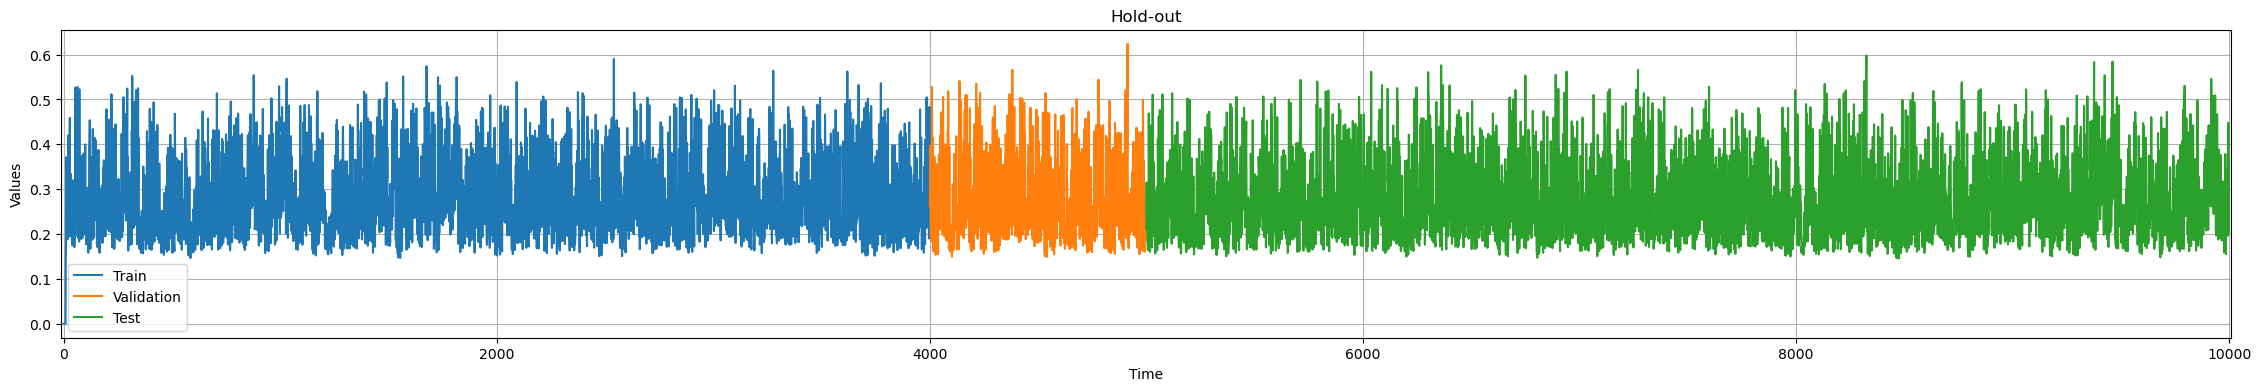

In [15]:
tr_dataset, dev_dataset, ts_dataset = source1[:4000], source1[4000:5000], source1[5000:]
# Although is not much representative, we plot the time target
show_split(tr_dataset, dev_dataset, ts_dataset)

### Grid search

In [16]:
json_dictionary = {}

In [17]:
ranges_to_explore = {
    "b_steps": [8, 10],
    "units": [10, 20, 50],
    "omega": [(0.5, 0.5), (0.7, 0.7)],
    "spectral": [0.8, 0.9],
    "transient": [50, 100],
    "lambda":[0.001, 0.0001]
}

gs = GridSearch(ranges_to_explore, tr_dataset, dev_dataset, "NARMA10")
best_config = gs.best_config

json_dictionary["best_config"] = best_config

Number of configurations to try:  96


100%|██████████| 96/96 [00:51<00:00,  1.85it/s]


The best solution in  ({'b_steps': 8, 'units': 20, 'omega': (0.7, 0.7), 'spectral': 0.9, 'transient': 50, 'lambda': 0.001}, 0.004392, 0.005524)


In [19]:
multiple_train(tr_dataset,best_config,"NARMA10",[dev_dataset, ts_dataset])

# tr_loss, hs, _, _  = best_model.validate(tr_dataset)
# print("Train Error", round(tr_loss.item(), 6))
#
# dev_loss, hs, _, _  = best_model.validate(dev_dataset, hs[-1])
# print("Validation Error", round(dev_loss.item(), 6))
#
# ts_loss = best_model.validate(ts_dataset, hs[-1])[0]
# print("Test Error", round(ts_loss.item(), 6))
#
# json_dictionary["best_config"] = best_config
# json_dictionary["Model_evaluation"] = (
#     round(tr_loss.item(),6),
#     round(dev_loss.item(),6),
#     round(ts_loss.item(),6))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 20)

### Final retrain with Training and Validation set (with the best configuration)

In [ ]:
from numpy import vstack

final_trainer = ESN_seq2seq(best_config["b_steps"], 1,
                            hidden_dim=best_config["units"],
                            omega=best_config["omega"],
                            spectral_radius=best_config["spectral"],
                            transient=best_config["transient"],
                            lamda=best_config["lambda"],
                            dt_type="NARMA10")

# we use both training and validation as a training set, using the best parameters
# found in the previous model selection

final_tr = vstack([tr_dataset,dev_dataset])
loss_tr, last_hs = final_trainer.fit(final_tr)


tr_loss, hs, tr_pred, tr_y = best_model.validate(tr_dataset)
print("Train Error", round(tr_loss.item(), 6))

ts_loss, _, ts_pred, ts_y = best_model.validate(ts_dataset, hs[-1])
print("Test Error", round(ts_loss.item(), 6))

json_dictionary["Final_retrain"] = (
    round(tr_loss.item(),6),
    round(ts_loss.item(),6))

In [ ]:
show_result(tr_pred, tr_y, ts_pred, ts_y)